Chinese Traffic Sign Database: http://www.nlpr.ia.ac.cn/pal/trafficdata/recognition.html

Steps:
 - Install Pytorch via Pip/Conda https://pytorch.org/get-started/locally/
 - Download dataset via link: https://disk.yandex.ru/d/Wu8hJ6JKbPHuPw
 - Extract dataset zip archive
 - Change `DATASET_DIR` accordingly
 - Run the whole notebook to assess weak model of `TrafficSignClassifier`
 - Modify code of `TrafficSignClassifier` to boost classification quality of test images. You can choose VGG, Resnet, Inception, DenseNet or something else.

In [1]:
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

import tqdm
from torch.utils.tensorboard import SummaryWriter

# Dataset

In [2]:
class TraffiSignDataset(Dataset):
    def __init__(self, dataset_dir: str, image_height: int, image_width: int, train: bool = False):
        super(TraffiSignDataset, self).__init__()
        self.dataset_dir = dataset_dir
        self.image_height = image_height
        self.image_width = image_width
        self.train = train
        
        dir_suffix = 'train' if self.train else 'test'
        label_name = 'TsignRecgTrain4170Annotation.txt' if self.train else 'TsignRecgTest1994Annotation.txt'
        
        self.image_dir = f'{self.dataset_dir}/images_{dir_suffix}/'
        self.label_path = f'{self.dataset_dir}/annotations_{dir_suffix}/{label_name}'

        self.image_names, self.x1y1x2y2s, self.labels = self._load_labels(self.label_path)
        
        self.transform = transforms.Compose(
            [ 
                transforms.ToTensor(),
                transforms.Normalize(IMAGE_MEAN, IMAGE_STD),
                
                # torchvision.transforms.ToTensor(),
                # torchvision.transforms.RandomCrop(IMAGE_HEIGHT - 4),
                # torchvision.transforms.RandomHorizontalFlip(),
                # torchvision.transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)), 
                # torchvision.transforms.Normalize(IMAGE_MEAN, IMAGE_STD),
            ]
        )

    @staticmethod
    def _load_labels(path):
        with open(path, 'r') as f:
            labels = f.readlines()
        labels = [label.strip().split(';') for label in labels]
        image_names = [label[0] for label in labels]
        x1y1x2y2s = [(int(label[3]), int(label[4]), int(label[5]), int(label[6])) for label in labels]
        labels = [int(label[-2]) for label in labels]
        return image_names, x1y1x2y2s, labels
        
    def __getitem__(self, index):
        image = self.get_np_image(index)
        image = np.array(image / 255, dtype=np.float32)
        image = self.transform(image)
        label = self.labels[index]
        return image, label
    
    def get_np_image(self, index):
        image = cv2.imread(f'{self.image_dir}/{self.image_names[index]}')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        x1, y1, x2, y2 = self.x1y1x2y2s[index]
        image = image[y1: y2, x1: x2, ...]
        image = cv2.resize(image, (self.image_width, self.image_height), interpolation=cv2.INTER_CUBIC)
        return image
    
    def __len__(self):
        return len(self.image_names)

In [3]:
def create_dataloader(dataset: Dataset, batch_size: int, num_workers: int, train: bool = False):
    return DataLoader(
        dataset=dataset, batch_size=batch_size, 
        shuffle=train, num_workers=num_workers,
        pin_memory=True, drop_last=False)


def evaluate(model: nn.Module, dataloader: DataLoader, train: bool = False):
    model.eval()
    
    correct = 0
    total = 0

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            # calculate outputs by running images through the network
            outputs = model(inputs)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    images = len(dataloader) * dataloader.batch_size
    prefix = "train" if train else "test"
    print(f'Accuracy of the network on the {images} {prefix} images: {(100 * correct / total):.2f} %')
    

def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

# Model

In [4]:
class Block(nn.Module):
    def __init__(self, num_layers, in_channels, out_channels, identity_downsample=None, stride=1):
        assert num_layers in [18, 34, 50, 101, 152], "should be a a valid architecture"
        super(Block, self).__init__()
        self.num_layers = num_layers
        if self.num_layers > 34:
            self.expansion = 4
        else:
            self.expansion = 1
        # ResNet50, 101, and 152 include additional layer of 1x1 kernels
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        if self.num_layers > 34:
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        else:
            # for ResNet18 and 34, connect input directly to (3x3) kernel (skip first (1x1))
            self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        if self.num_layers > 34:
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

class ResNet(nn.Module):
    def __init__(self, num_layers, block, image_channels, num_classes):
        assert num_layers in [18, 34, 50, 101, 152], f'ResNet{num_layers}: Unknown architecture! Number of layers has ' \
                                                     f'to be 18, 34, 50, 101, or 152 '
        super(ResNet, self).__init__()
        if num_layers < 50:
            self.expansion = 1
        else:
            self.expansion = 4
        if num_layers == 18:
            layers = [2, 2, 2, 2]
        elif num_layers == 34 or num_layers == 50:
            layers = [3, 4, 6, 3]
        elif num_layers == 101:
            layers = [3, 4, 23, 3]
        else:
            layers = [3, 8, 36, 3]
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNetLayers
        self.layer1 = self.make_layers(num_layers, block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self.make_layers(num_layers, block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self.make_layers(num_layers, block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self.make_layers(num_layers, block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * self.expansion, num_classes)
        
        # self.dropout = nn.Dropout(0.15)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        # x = self.dropout(x)
        x = self.fc(x)
        return x

    def make_layers(self, num_layers, block, num_residual_blocks, intermediate_channels, stride):
        layers = []

        identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels*self.expansion, kernel_size=1, stride=stride),
                                            nn.BatchNorm2d(intermediate_channels*self.expansion))
        layers.append(block(num_layers, self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels * self.expansion # 256
        for i in range(num_residual_blocks - 1):
            layers.append(block(num_layers, self.in_channels, intermediate_channels)) # 256 -> 64, 64*4 (256) again
        return nn.Sequential(*layers)


def ResNet18(img_channels=3, num_classes=1000):
    return ResNet(18, Block, img_channels, num_classes)

# Parameters

In [6]:
DATASET_DIR = '/home/parallels/Desktop/02_Traffic_Sign_Classification/traffic_sign_dataset'

NUM_CLASSES = 58

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

IMAGE_MEAN = [0.485, 0.456, 0.406]  #normalize params
IMAGE_STD = [0.229, 0.224, 0.225]

BATCH_SIZE = 16
NUM_WORKERS = 2
EPOCHS = 8

# Augmentation

In [7]:
transform1 = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomCrop(IMAGE_HEIGHT - 4),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)), 
    torchvision.transforms.Normalize(IMAGE_MEAN, IMAGE_STD),
])

# Datasets

In [8]:
train_dataset = TraffiSignDataset(
    dataset_dir=DATASET_DIR, image_height=IMAGE_HEIGHT, image_width=IMAGE_WIDTH, train=True)

test_dataset = TraffiSignDataset(
    dataset_dir=DATASET_DIR, image_height=IMAGE_HEIGHT, image_width=IMAGE_WIDTH)

train_dataloader = create_dataloader(
    train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, train=True)

test_dataloader = create_dataloader(
    test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

In [9]:
# train_dataset.transform = transform1

# Data examples

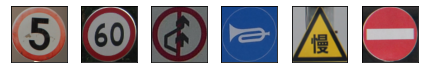

In [10]:
indices = [0, 200, 400, 600, 800, 1000]
plot([train_dataset.get_np_image(index) for index in indices]);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


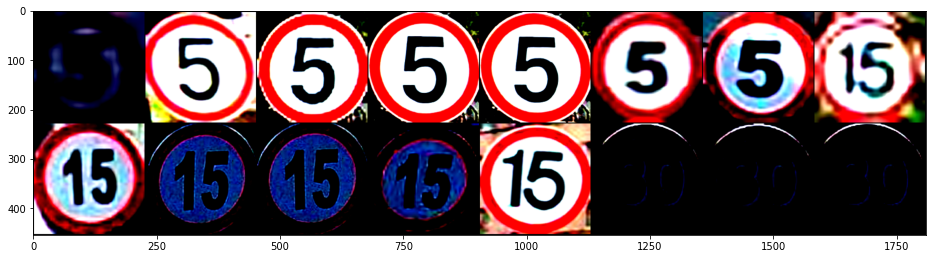

In [11]:
images, _ = next(iter(test_dataloader))
plt.figure(figsize=(16, 8))
plt.imshow(torchvision.utils.make_grid(images).permute(1, 2, 0));

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = ResNet18(img_channels=3, num_classes=NUM_CLASSES).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
writer = SummaryWriter('runs/traffic_sign_classifier')

# Training

In [14]:
model.train()

for epoch in tqdm.tqdm(range(EPOCHS)):  # loop over the dataset multiple times
    running_loss = 0.0

    for i, data in enumerate(train_dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            # print(f'epoch: {epoch:2d}, iteration: {i + 1:4d}, loss: {running_loss / 100:.3f}')
            writer.add_scalar('training loss', running_loss / 100, epoch * len(train_dataloader) + i)
            running_loss = 0.0
            
model.eval();

100%|██████████████████████████████████████████| 8/8 [1:04:12<00:00, 481.52s/it]


# Saving model

In [15]:
torch.save(model.state_dict(), './traffic_sign_classifier.pth')

# Loading model

In [16]:
model.load_state_dict(torch.load('./traffic_sign_classifier.pth'))
model.eval();

In [17]:
evaluate(model, train_dataloader, train=True)

Accuracy of the network on the 4176 train images: 99.95 %


In [18]:
evaluate(model, test_dataloader, train=False)

Accuracy of the network on the 2000 test images: 90.87 %


# What's next?

In order to boost classfication accuracy you can:
- [x] Use State-Of-The-Art model architecture (ResNet18)
- [x] Play with learning_rate of optimizer (0.001)
- [x] Change optimizer from SGD to Adam 
- [x] Increase image resolution (basic for ResNet)
 - Add image augmenations
 - Add dropout
 
the last two did not give a big increase